# Linear Regression Model

***import library***

In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns

from sklearn.metrics import r2_score

import os
import datetime
from math import sqrt

import math
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, SimpleRNN

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D, Dropout, Flatten
from tensorflow.keras import  regularizers

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
import tensorflow.keras.backend as K
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error


#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator

pd.set_option('max_columns', 50)

***import data***

In [2]:

#import data
data = pd.read_csv("../H264 REVISED/H264-data/nbc_news_G16B1_QP10.csv",
                   names=['decoded_frame','arrival_time', 'video_frame', 
                                         'frame_size', 'x', 'y', 'z'])


In [3]:
data.head()

,decoded_frame,arrival_time,video_frame,frame_size,x,y,z
0,0,0.00000,I,277192,52.340,52.340,52.568
1,2,66.66667,P,257984,50.030,50.897,51.285
2,1,33.33333,B,182048,47.967,49.606,50.288
3,4,133.33333,P,257248,50.063,50.856,51.186
4,3,100.00000,B,180624,48.031,49.683,50.401


In [4]:
data.dropna(0,inplace= True)

In [5]:
#drop decoded frame column
data.drop(('decoded_frame'), axis=1, inplace=True)

#data.drop(('x'), axis=1, inplace=True)
#data.drop(('y'), axis=1, inplace=True)
#data.drop(('z'), axis=1, inplace=True)

In [6]:
# Label encoding of species column numerically
le = LabelEncoder()
le.fit(data['video_frame'])
print(list(le.classes_))
data['video_frame'] = le.transform(data['video_frame'])

['B', 'I', 'P']


In [7]:
data.head()

,arrival_time,video_frame,frame_size,x,y,z
0,0.00000,1,277192,52.340,52.340,52.568
1,66.66667,2,257984,50.030,50.897,51.285
2,33.33333,0,182048,47.967,49.606,50.288
3,133.33333,2,257248,50.063,50.856,51.186
4,100.00000,0,180624,48.031,49.683,50.401


In [8]:
print(data.video_frame.value_counts())

0    24761
2    21666
1     3096
Name: video_frame, dtype: int64


In [9]:
data.sort_values('arrival_time').head()

,arrival_time,video_frame,frame_size,x,y,z
0,0.00000,1,277192,52.340,52.340,52.568
2,33.33333,0,182048,47.967,49.606,50.288
1,66.66667,2,257984,50.030,50.897,51.285
4,100.00000,0,180624,48.031,49.683,50.401
3,133.33333,2,257248,50.063,50.856,51.186


In [10]:
data.sort_values('arrival_time', inplace=True)

In [11]:
#Check for missing values
print("total number of rows : {0}".format(len(data)))
print("number of rows missing traffic: {0}".format(len(data.loc[data['frame_size'] == 0])))
print(data.head())

#Fill missing values
data = data.replace(0, np.nan) # first replace 0 values with nan values, otherwise fill function doesnot work
#daily_data.fillna(method= 'bfill', inplace=True) # fill using backward fill pandas function
data.interpolate(method= 'linear', inplace=True)


#Check how many other missing(zero) values
print("total number of rows : {0}".format(len(data)))
print("number of rows missing traffic: {0}".format(len(data.loc[data['frame_size'] == 0])))
print(data.head())

total number of rows : 49523
number of rows missing traffic: 0
   arrival_time  video_frame  frame_size       x       y       z
0       0.00000            1      277192  52.340  52.340  52.568
2      33.33333            0      182048  47.967  49.606  50.288
1      66.66667            2      257984  50.030  50.897  51.285
4     100.00000            0      180624  48.031  49.683  50.401
3     133.33333            2      257248  50.063  50.856  51.186
total number of rows : 49523
number of rows missing traffic: 0
   arrival_time  video_frame  frame_size       x       y       z
0           NaN          1.0      277192  52.340  52.340  52.568
2      33.33333          1.5      182048  47.967  49.606  50.288
1      66.66667          2.0      257984  50.030  50.897  51.285
4     100.00000          2.0      180624  48.031  49.683  50.401
3     133.33333          2.0      257248  50.063  50.856  51.186


In [12]:
for obs in range(1,10):
    data["T_" + str(obs)] = data.frame_size.shift(obs)

In [13]:
data.fillna(0.00,inplace=True)
data.head(10)

,arrival_time,video_frame,frame_size,x,y,z,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
0,0.00000,1.0,277192,52.340,52.340,52.568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.33333,1.5,182048,47.967,49.606,50.288,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66.66667,2.0,257984,50.030,50.897,51.285,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100.00000,2.0,180624,48.031,49.683,50.401,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133.33333,2.0,257248,50.063,50.856,51.186,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0
6,166.66667,2.0,180336,48.037,49.613,50.326,257248.0,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0
5,200.00000,2.0,253616,50.037,50.830,51.145,180336.0,257248.0,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0
8,233.33333,2.0,180648,47.999,49.579,50.294,253616.0,180336.0,257248.0,180624.0,257984.0,182048.0,277192.0,0.0,0.0
7,266.66667,2.0,251768,50.010,50.748,51.168,180648.0,253616.0,180336.0,257248.0,180624.0,257984.0,182048.0,277192.0,0.0
10,300.00000,2.0,182696,48.050,49.518,50.240,251768.0,180648.0,253616.0,180336.0,257248.0,180624.0,257984.0,182048.0,277192.0


In [14]:
predictors = ['T_1','T_2', 'T_3', 'T_4', 'T_5','T_6', 'T_7', 'T_8', 'T_9']


X = data[predictors]
X.index = data['arrival_time']
X.head()

,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
arrival_time,,,,,,,,,
0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33.33333,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.66667,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.00000,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0
133.33333,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0


In [15]:
target_name = ['frame_size']

#X = data.drop('frame_size', axis=1)
y = data[target_name]

In [16]:
X.shape

(49523, 9)

In [17]:
y.shape

(49523, 1)

In [18]:
from sklearn.model_selection import train_test_split

test_size = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [19]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39618, 9) (39618, 1) (9905, 9) (9905, 1)


In [20]:
# Model

from sklearn.linear_model import LinearRegression
# 2. Create an instance of the estimator
linear_regression = LinearRegression()
# 3. Use the trainning data to train the estimator
linear_regression.fit(X_train, y_train)

#Coefficient
coefficients = linear_regression.coef_
#intercept
intercept = linear_regression.intercept_

#Slope
print("Slope :", coefficients[0])

#Intercept
print("Intercept: ", intercept)

Slope : [ 0.16090035  0.32090067 -0.01763529  0.24336099 -0.04651424  0.18773532
 -0.0722709   0.1776705  -0.05092606]
Intercept:  [22533.90520074]


In [21]:

models = pd.DataFrame(index=['RPE', 'MAE', 'MAPE'], 
                      columns=[ 'seq2seq', 'LSTM', 'CNN'])

In [22]:
#Prediction

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

y_pred=linear_regression.predict(X_test)


def relative_percent_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred))/np.sum(abs(y_true)) * 100
    
def mean_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) * 100


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    


#models.loc['RPE','Linear Regression'] = round(relative_percent_error(y_test, y_pred), 2)
#models.loc['MAE','Linear Regression'] = mean_absolute_error(y_test, y_pred)
#models.loc['MAPE','Linear Regression'] = mean_absolute_percentage_error(y_test, y_pred)


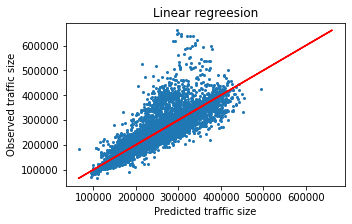

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(linear_regression.predict(X_test), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('Linear regreesion')
ax.set_xlabel('Predicted traffic size')
ax.set_ylabel('Observed traffic size');

In [24]:
print(models)

     seq2seq LSTM  CNN
RPE      NaN  NaN  NaN
MAE      NaN  NaN  NaN
MAPE     NaN  NaN  NaN


# seq2seq2 Model

In [25]:
predictors = ['T_1','T_2', 'T_3', 'T_4', 'T_5','T_6', 'T_7', 'T_8', 'T_9']


X = data[predictors]
X.index = data['arrival_time']
X.head()

,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
arrival_time,,,,,,,,,
0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33.33333,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.66667,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.00000,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0
133.33333,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0


In [26]:
target_name = ['frame_size']

#X = data.drop('frame_size', axis=1)
y = data[target_name]

In [27]:
X.shape

(49523, 9)

In [28]:
y.shape

(49523, 1)

In [29]:
from sklearn.model_selection import train_test_split

test_size = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [30]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39618, 9) (39618, 1) (9905, 9) (9905, 1)


In [31]:
#---NORMALIZE DATA---

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(39618, 9) (39618, 1)
(9905, 9) (9905, 1)


In [32]:
# num of input signals
#input_dim = X_train.shape[1]
# num of output signals
#output_dim = y_train.shape[1]


input_seq_len = 8  
output_seq_len = 1
num_input_features =  X_train.shape[1]
print(num_input_features)
num_output_features = y_train.shape[1]
print(num_output_features)
batch_size = 10

9
1


In [33]:

#input_seq_len = 30
#output_seq_len = 5

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

In [34]:
X_train, y_train = generate_train_samples()
print(X_train.shape, y_train.shape)

(39609, 8, 9) (39609, 1, 1)


In [35]:
input_seq, output_seq = generate_train_samples()
print(input_seq.shape, output_seq.shape)

(39609, 8, 9) (39609, 1, 1)


In [36]:
# Define an input series and encode it with an LSTM. 

encoder_inputs = tf.keras.layers.Input(shape=(None, num_input_features)) 
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

In [37]:
# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = tf.keras.layers.Input(shape=(None, 1)) 


# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(128,  return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 9)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 70656       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  66560       input_2[0][0]                    
                                                                 lstm[0][1]                   

In [38]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='mse', optimizer= optimizer, metrics=[ 'mse'])

In [39]:
#input_seq, output_seq = generate_train_samples(X_train)

encoder_input_data = input_seq
decoder_target_data = output_seq
decoder_input_data = np.zeros(decoder_target_data.shape)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs= 100,
                             validation_split=0.1, 
                             shuffle=False)

Epoch 1/100
3565/3565 [==============================] - 23s 5ms/step - loss: 0.0618 - mse: 0.0618 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 2/100
3565/3565 [==============================] - 17s 5ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 3/100
3565/3565 [==============================] - 17s 5ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 4/100
3565/3565 [==============================] - 16s 5ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 5/100
3565/3565 [==============================] - 16s 5ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 6/100
3565/3565 [==============================] - 17s 5ms/step - loss: 0.0589 - mse: 0.0589 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 7/100
3565/3565 [==============================] - 17s 5ms/step - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 8/100
3565/3565 [=========================

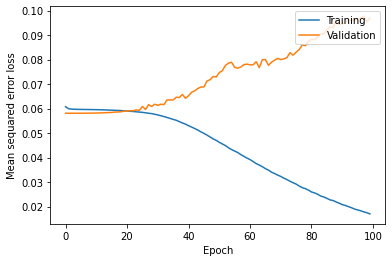

In [40]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model Loss')
plt.ylabel('Mean sequared error loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [41]:
# define inference encoder
n_units = 128

encoder_model = tf.keras.Model(encoder_inputs, encoder_states)
    
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = tf.keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [42]:
def predict(x, encoder_model, decoder_model, num_steps_to_predict):
    
    y_predicted = []

    # Encode the values as a state vector
    states = encoder_model.predict(x)

    # The states must be a list
    if not isinstance(states, list):
        states = [states]

    # Generate first value of the decoder input sequence
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_model.predict([decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # add predicted value
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [43]:
def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [44]:
X_test, y_test = generate_test_samples()
print(X_test.shape, y_test.shape)

(9896, 8, 9) (9896, 1, 1)


In [45]:
#from utils import plot_prediction
num_steps_to_predict = output_seq_len
y_test_predicted = predict(X_test, encoder_model, decoder_model, num_steps_to_predict)
y_test_predicted.shape

(9896, 1, 1)

In [46]:
y_test.shape

(9896, 1, 1)

In [47]:
y_test_predicted = y_test_predicted.reshape(y_test_predicted.shape[0], y_test_predicted.shape[1])
y_test_predicted_inv = scaler.inverse_transform(y_test_predicted)

y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test_inv = scaler.inverse_transform(y_test)

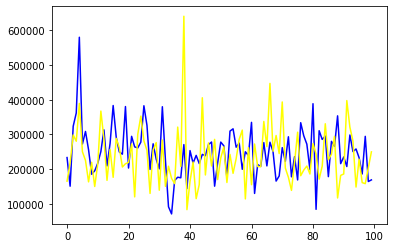

In [48]:

plt.plot(y_test_predicted_inv[:100], label = "pred", color ='blue')
plt.plot(y_test_inv[:100], label = "actual", color= 'yellow')
plt.show()

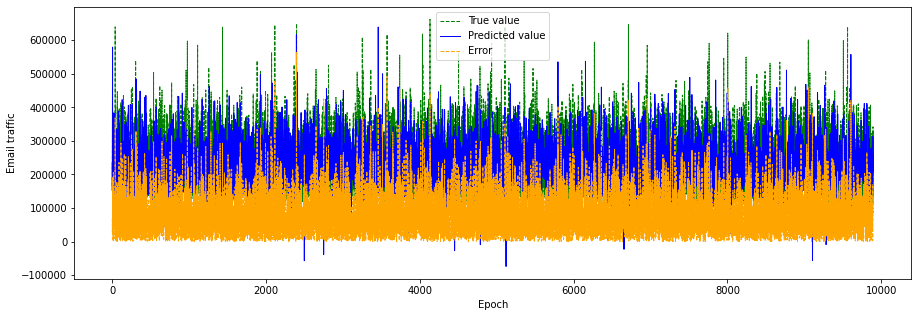

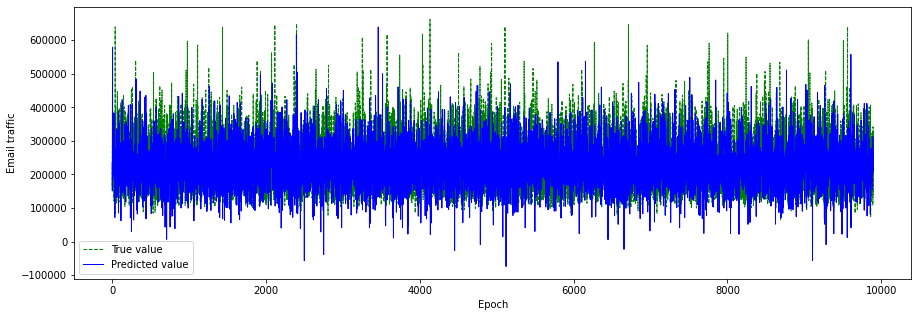

In [49]:
#********************* Actual value, Predicted value and Prediction Error ***************

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot(y_test_inv[:,0], label="True value", linewidth=1,linestyle="--",color= 'green')
plt.plot(y_test_predicted_inv[:,0], label="Predicted value", linewidth=1,color='blue')

error = abs(y_test_inv[:,0] - y_test_predicted_inv[:,0])

plt.plot(error, label='Error',color= 'orange', linewidth=1, linestyle="--")
plt.legend()
plt.show()

#******************************* True value vs Prediction **********************/

plt.figure(figsize = (15, 5))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot (y_test_inv[:,0], label="True value", linewidth=1,color= 'green', linestyle="--")
plt.plot(y_test_predicted_inv[:,0], label="Predicted value", linewidth=1,color='blue')
plt.legend()
plt.show()

In [50]:
#Prediction


models.loc['RPE','seq2seq'] = round(relative_percent_error(y_test, y_test_predicted), 2)
models.loc['MAE','seq2seq'] = mean_absolute_error(y_test, y_test_predicted)
models.loc['MAPE','seq2seq'] = mean_absolute_percentage_error(y_test, y_test_predicted)

In [51]:
print(y_test_predicted.shape, y_test.shape)

(9896, 1) (9896, 1)


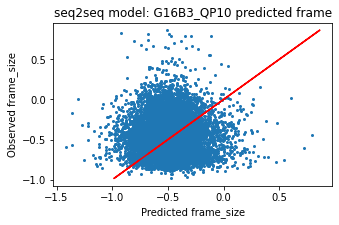

In [52]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter((y_test_predicted), y_test, s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('seq2seq model: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# LSTM models

In [53]:
predictors = ['T_1','T_2', 'T_3', 'T_4', 'T_5','T_6', 'T_7', 'T_8', 'T_9']


X = data[predictors]
X.index = data['arrival_time']
X.head()

,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
arrival_time,,,,,,,,,
0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33.33333,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.66667,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.00000,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0
133.33333,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X.head(5)

,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
arrival_time,,,,,,,,,
0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33.33333,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66.66667,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.00000,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0,0.0
133.33333,180624.0,257984.0,182048.0,277192.0,0.0,0.0,0.0,0.0,0.0


In [55]:
target_name = ['frame_size']

#X = data.drop('frame_size', axis=1)
y = data[target_name]

In [56]:
y.head(5)

,frame_size
0,277192
2,182048
1,257984
4,180624
3,257248


In [57]:
X.shape

(49523, 9)

In [58]:
y.shape

(49523, 1)

In [59]:
from sklearn.model_selection import train_test_split

test_size = 0.2
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [60]:
#---NORMALIZE DATA---

scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(39618, 9) (39618, 1)
(9905, 9) (9905, 1)


In [61]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39618, 9) (39618, 1) (9905, 9) (9905, 1)


In [62]:
def create_data_sequence(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    input_sequence, output = [], []
    for i in range(len(X) - time_steps):
        sequence = X[i:(i + time_steps), :]
        
        input_sequence.append(sequence)        
        output.append(y[i + time_steps])
    return np.array(input_sequence), np.array(output)

In [63]:
time_steps = 8
X_train, y_train = create_data_sequence(X_train, y_train, time_steps)
X_test, y_test = create_data_sequence(X_test, y_test, time_steps)

In [64]:
# We get training and test set sequences as [samples, time_steps, n_features]
y_train = y_train.reshape(y_train.shape[0],1,  y_train.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print("Training data shape", X_train.shape, "Training data output shape", y_train.shape)
print("Test data shape", X_test.shape, "Test data output shape", y_test.shape)

Training data shape (39610, 8, 9) Training data output shape (39610, 1, 1)
Test data shape (9897, 8, 9) Test data output shape (9897, 1, 1)


In [65]:
input_shape=(X_train.shape[1], X_train.shape[2])
input_shape

(8, 9)

In [66]:
num_x_signals = X.shape[1]
num_x_signals

9

In [67]:
num_y_signals = y.shape[1]
num_y_signals

1

In [68]:
def model_lstm():
    
    model = tf.keras.models.Sequential()
    
    model.add(LSTM(128, activation='relu', return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(LSTM(100, activation='relu'))
    model.add(Dense(num_y_signals))
    model.compile(optimizer= 'adam', loss='mae')
    #model.compile(loss='mae', optimizer='adam', metrics=['mse']) # mse = mean squared error
    
    return model

In [69]:
model_lstm = model_lstm()

history_lstm = model_lstm.fit(
    X_train,
    y_train, 
    epochs=100, 
    batch_size=64, 
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/100
558/558 [==============================] - 6s 7ms/step - loss: 0.2265 - val_loss: 0.1935
Epoch 2/100
558/558 [==============================] - 4s 7ms/step - loss: 0.1933 - val_loss: 0.1930
Epoch 3/100
558/558 [==============================] - 3s 6ms/step - loss: 0.1930 - val_loss: 0.1929
Epoch 4/100
558/558 [==============================] - 4s 6ms/step - loss: 0.1929 - val_loss: 0.1928
Epoch 5/100
558/558 [==============================] - 3s 6ms/step - loss: 0.1928 - val_loss: 0.1927
Epoch 6/100
558/558 [==============================] - 4s 6ms/step - loss: 0.1927 - val_loss: 0.1927
Epoch 7/100
558/558 [==============================] - 3s 6ms/step - loss: 0.1927 - val_loss: 0.1927
Epoch 8/100
558/558 [==============================] - 3s 6ms/step - loss: 0.1926 - val_loss: 0.1927
Epoch 9/100
558/558 [==============================] - 4s 6ms/step - loss: 0.1926 - val_loss: 0.1926
Epoch 10/100
558/558 [==============================] - 4s 6ms/step - loss: 0.1926 - val_lo

In [70]:
X_test.shape

(9897, 8, 9)

In [71]:
yhat_lstm = model_lstm.predict(X_test)
print (yhat_lstm.shape)

(9897, 8, 1)


In [72]:
y_test.shape

(9897, 1, 1)

In [73]:
def relative_percent_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred))/np.sum(abs(y_true)) * 100

In [74]:
# Prediction !!!!
    

models.loc['RPE','LSTM'] = round(relative_percent_error(y_test, yhat_lstm), 2)
models.loc['MAE','LSTM'] = mean_absolute_error(y_test, yhat_lstm)
models.loc['MAPE','LSTM'] = mean_absolute_percentage_error(y_test, yhat_lstm)

In [75]:
print(yhat_lstm.shape, y_test.shape)


(9897, 8, 1) (9897, 1, 1)


In [76]:
yhat_lstm = yhat_lstm.reshape((yhat_lstm.shape[0], yhat_lstm.shape[1]))
print(yhat_lstm.shape)

(9897, 8)


In [77]:
y_test = y_test.reshape((len(y_test),1))
print(y_test.shape)

(9897, 1)


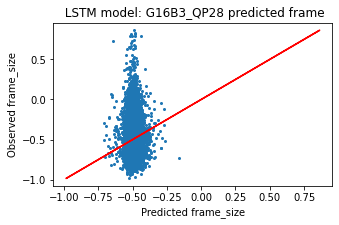

In [78]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(yhat_lstm[:,0], y_test[:,0], s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title(' LSTM model: G16B3_QP28 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

# CNN model

In [79]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39610, 8, 9) (39610, 1, 1) (9897, 8, 9) (9897, 1)


In [80]:
#********************Build Model****************************

def cnn_model():
    
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, strides=1,
                      input_shape=(X_train.shape[1], X_train.shape[2]
                    )))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
      
    return model

In [81]:
model_cnn =cnn_model()

history_cnn = model_cnn.fit(X_train, y_train, batch_size = 32,validation_split=0.2, epochs = 100, verbose=1,
                     shuffle=False)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 32)             896       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 97        
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
991/991 [==============================] - 1s 1ms/step - loss: 0.1010 - val_loss: 0.0601
Epoch 2/100
991/991 [

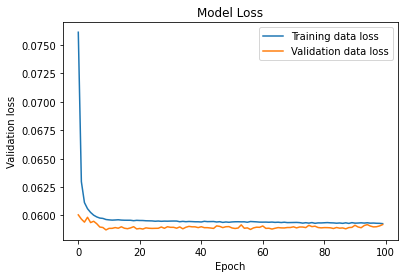

In [82]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

In [83]:
# Prediction Time !!!!
yhat_cnn = model_cnn.predict(X_test)


models.loc['RPE','CNN'] = round(relative_percent_error(y_test, yhat_cnn), 2)
models.loc['MAE','CNN'] = mean_absolute_error(y_test, yhat_cnn)
models.loc['MAPE','CNN'] = mean_absolute_percentage_error(y_test, yhat_cnn)

In [84]:
models

,seq2seq,LSTM,CNN
RPE,50.84,339.11,40.22
MAE,24.191582,20.1698,19.137156
MAPE,208.675488,211.158892,202.859881


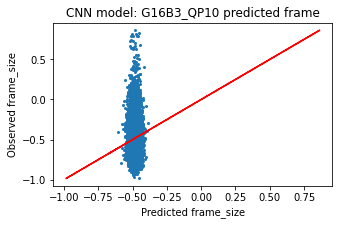

In [85]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(yhat_cnn[:,0], y_test[:,0] , s=4)
ax.plot(y_test, y_test, color='red')
ax.set_title('CNN model: G16B3_QP10 predicted frame')
ax.set_xlabel('Predicted frame_size')
ax.set_ylabel('Observed frame_size');

In [86]:
models

,seq2seq,LSTM,CNN
RPE,50.84,339.11,40.22
MAE,24.191582,20.1698,19.137156
MAPE,208.675488,211.158892,202.859881


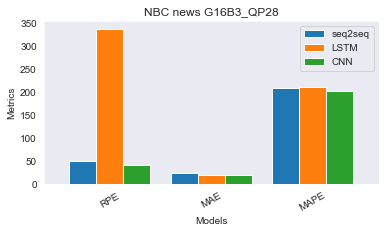

In [87]:
import seaborn as sns
sns.set_style("dark")


models.plot(kind='bar', width=0.8, figsize=(6,3))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title('NBC news G16B3_QP28');
plt.xlabel('Models')
plt.ylabel('Metrics')
#ax2.set_ylabel('mape')

plt.show()

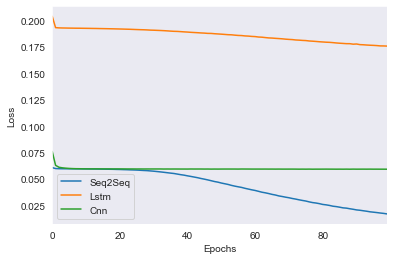

In [88]:
# Loss of the model

def plot_history(histories, key=  'loss'):
  #plt.figure(figsize=(15,10))
    
  for name, history in histories:
    plt.plot(history.epoch, history.history[key],
             label=name.title())
    
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.xlim([0,max(history.epoch)])


plot_history([('seq2seq', history),
              ('LSTM', history_lstm),
              ('CNN', history_cnn)])